In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VR con el número de retardos sugerido
    vr_model = ClimateVR(all_data)
    vr_results = vr_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = vr_model.predict(vr_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
vr_model = ClimateVR(all_data)
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)


[I 2024-09-22 21:34:54,318] A new study created in memory with name: no-name-a504ee43-4084-47f2-a8ae-07d5ebc6839b
[I 2024-09-22 21:34:54,322] Trial 0 finished with value: 54.782084620437224 and parameters: {'maxlags': 2}. Best is trial 0 with value: 54.782084620437224.
[I 2024-09-22 21:34:54,324] Trial 1 finished with value: 62.85549815141822 and parameters: {'maxlags': 1}. Best is trial 0 with value: 54.782084620437224.
[I 2024-09-22 21:34:54,331] Trial 2 finished with value: 2.6523204346159597e-09 and parameters: {'maxlags': 10}. Best is trial 2 with value: 2.6523204346159597e-09.
[I 2024-09-22 21:34:54,335] Trial 3 finished with value: 4.180598818470763e-09 and parameters: {'maxlags': 7}. Best is trial 2 with value: 2.6523204346159597e-09.
[I 2024-09-22 21:34:54,341] Trial 4 finished with value: 4.777727752160371e-09 and parameters: {'maxlags': 8}. Best is trial 2 with value: 2.6523204346159597e-09.
[I 2024-09-22 21:34:54,347] Trial 5 finished with value: 3.987955394057324e-09 and p

Número óptimo de retardos: 10
RMSE óptimo: 2.6523204346159597e-09
Valores predichos:
[[ 8.34085598e-02 -4.03784196e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-5.80390853e-03 -3.24406143e-02 -9.81253506e-03 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-1.10228410e-01  4.30274506e-02  1.67757916e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31829837e-02 -9.24476064e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648763e-01  2.06355232e-01  2.85916996e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89872630e-02 -1.61854637e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


In [4]:
all_data

,AAPL,BEP,FSLR,GOOG,IBM,NEE,NVDA,TSLA,VWDRY,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions,GDP,TB3MS,CPI
0,-0.071891,0.004221,-0.086066,-0.028478,-0.010668,0.018201,-0.043872,-0.090422,-0.017129,3.434062,104.00,-0.107713,-0.079697,0.035305,-0.045066,17912.079,0.02,237.430
1,0.061424,0.039767,-0.051121,0.015426,-0.044440,0.027754,-0.042394,-0.084574,0.078838,0.239178,103.25,-0.140308,-0.024601,0.005973,-0.049579,18063.529,0.03,234.747
2,0.100777,-0.030332,0.411862,0.044676,0.063701,-0.045986,0.153383,-0.001277,0.076154,0.835308,111.25,-0.117793,0.071572,0.034858,-0.002740,18063.529,0.03,234.747
3,-0.031372,0.026324,0.000669,-0.018625,-0.008892,0.005703,-0.051224,-0.071653,-0.007800,2.247921,117.20,-0.185240,0.017076,0.057500,-0.029565,18063.529,0.03,234.747
4,0.005786,0.032932,-0.002007,-0.016760,0.067227,-0.029986,0.060679,0.197489,0.094161,0.825789,125.25,-0.163193,0.027977,0.012721,-0.034143,18279.784,0.02,236.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.113780,0.197978,0.107617,0.068795,0.108671,0.011769,0.146886,0.195379,0.282913,1.999337,124.75,-0.087308,0.020830,0.012984,-0.000491,27956.998,5.34,307.531
108,0.013583,0.060961,0.091900,0.052345,0.031471,0.038113,0.058934,0.034988,0.145197,2.834145,114.50,-0.225731,-0.062126,0.004378,-0.064475,27956.998,5.34,307.531
109,-0.042227,-0.010274,-0.150801,0.006173,0.122959,-0.034738,0.242417,-0.246257,-0.112488,-2.182826,98.80,0.167510,0.120100,0.010273,0.081480,28269.174,5.22,309.685
110,-0.018543,-0.124793,0.051880,-0.014245,0.016644,-0.050057,0.285809,0.077901,-0.007519,2.395689,72.75,-0.041299,0.006871,0.007048,0.000088,28269.174,5.22,309.685


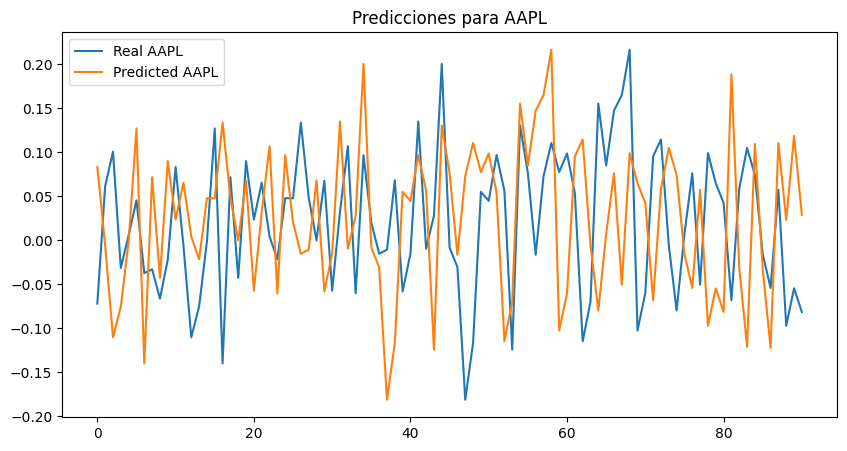

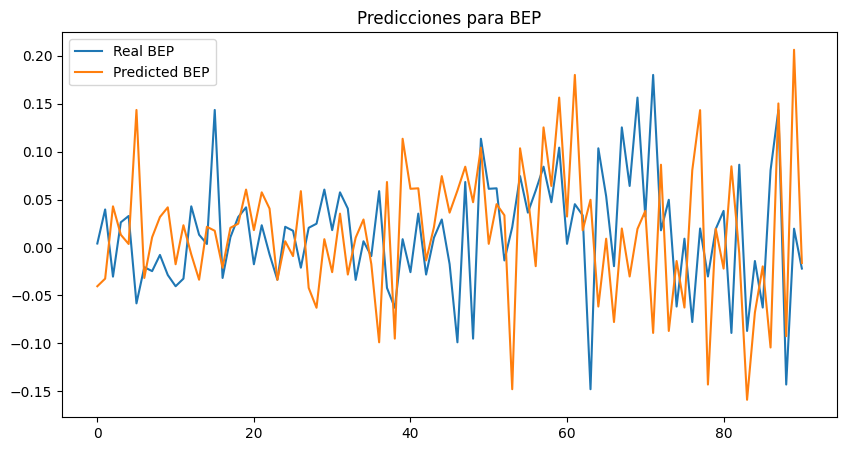

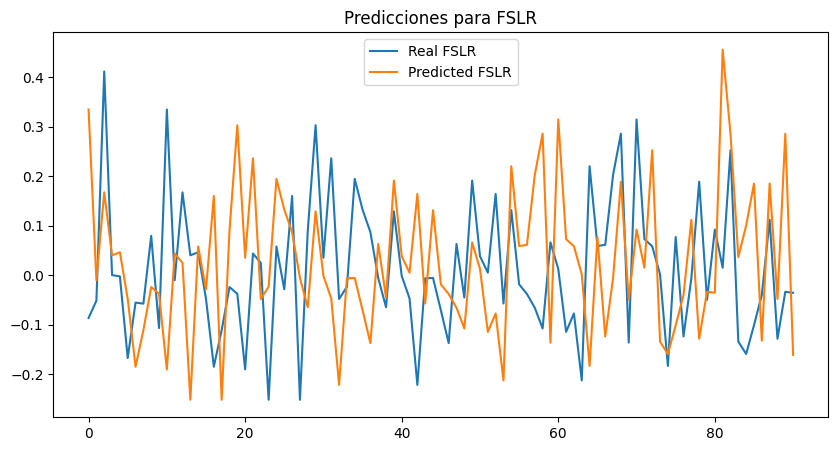

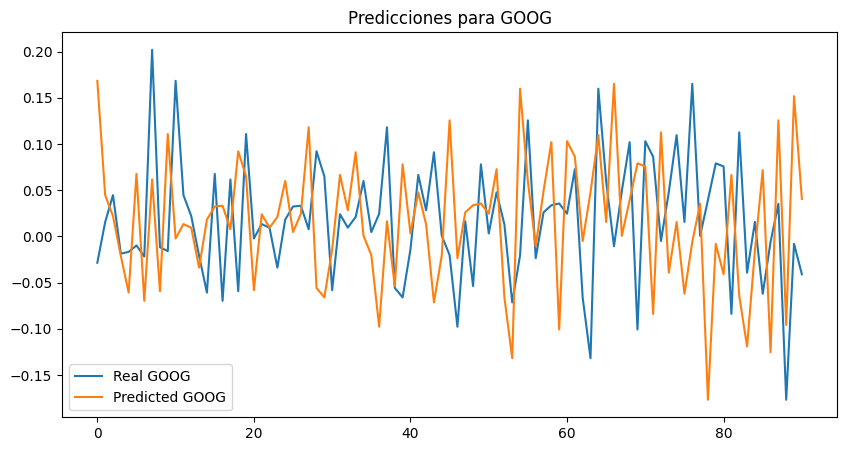

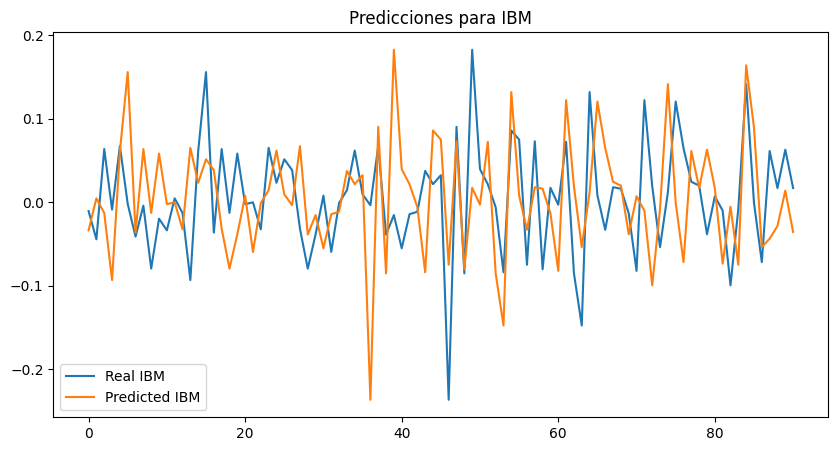

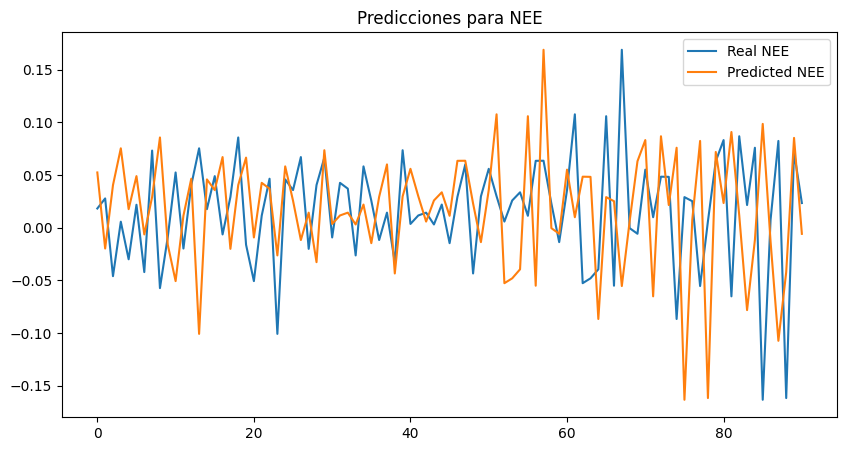

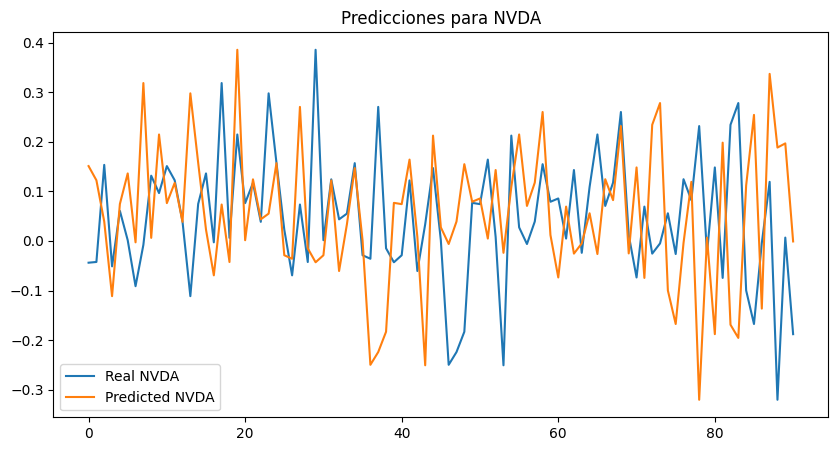

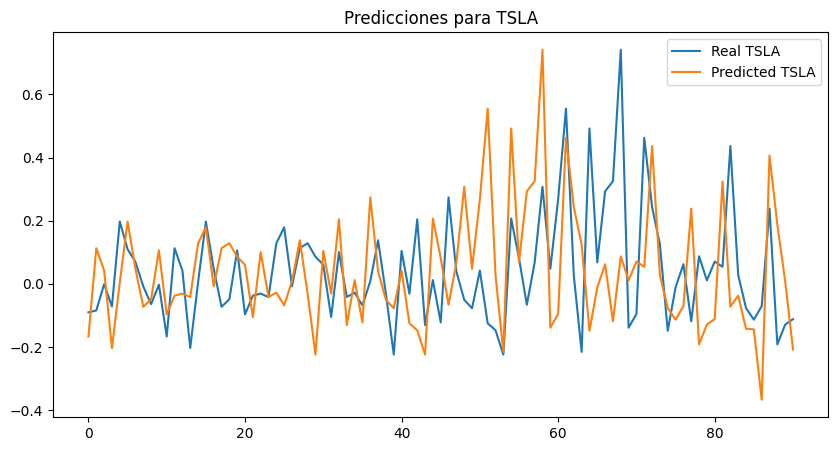

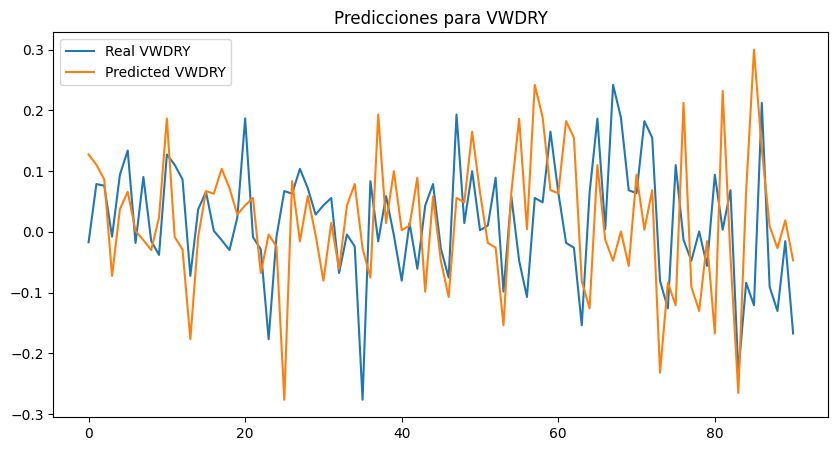

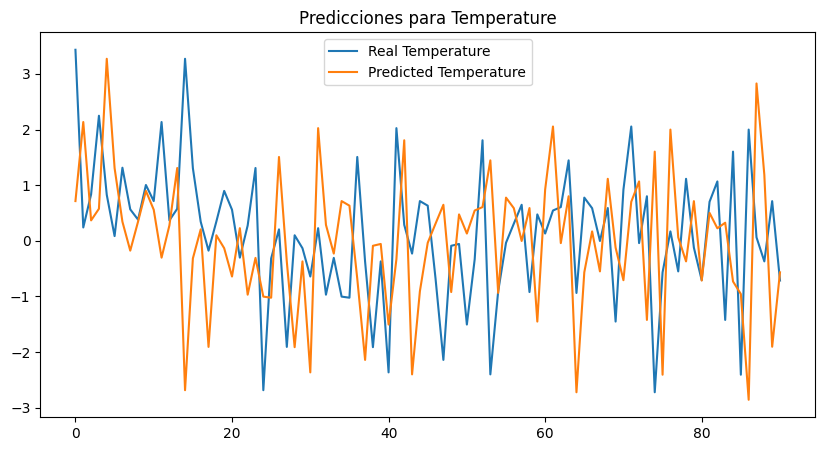

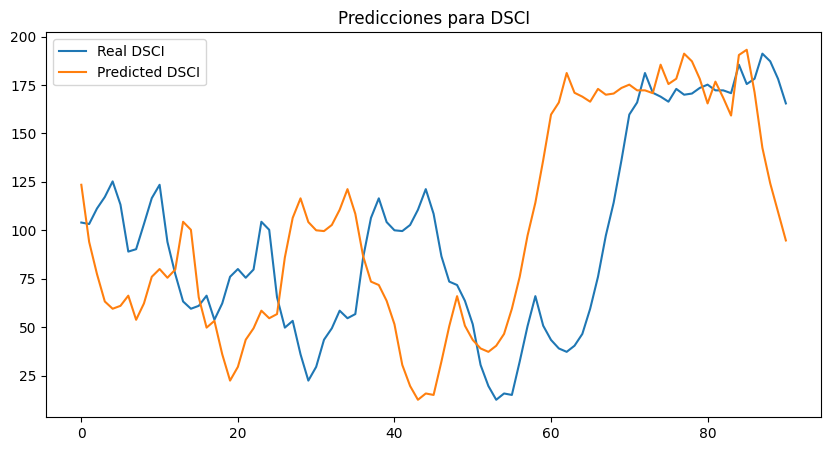

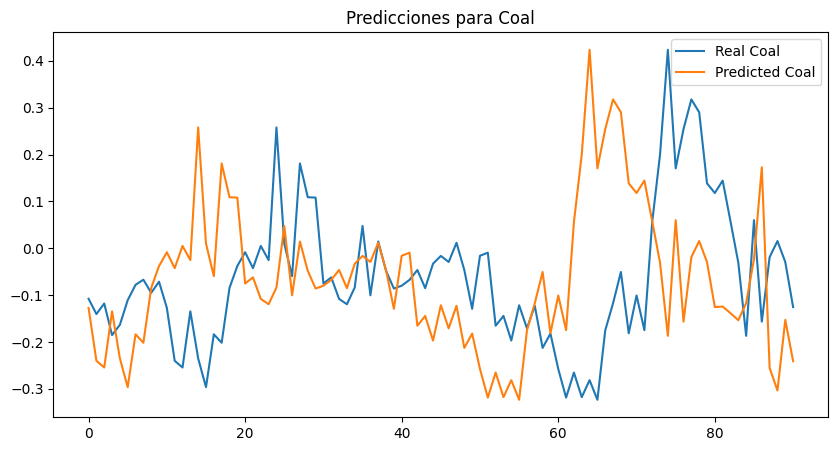

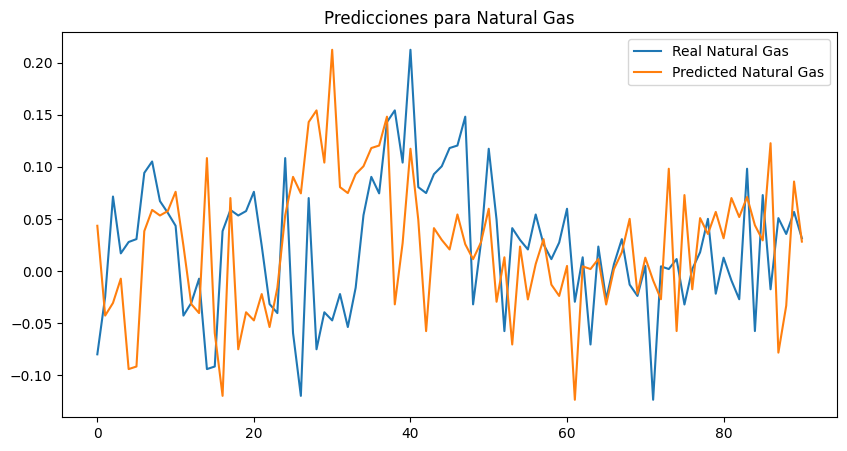

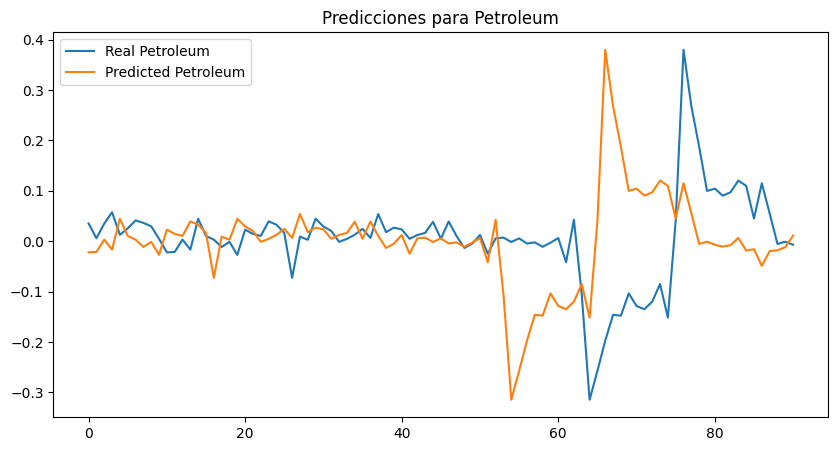

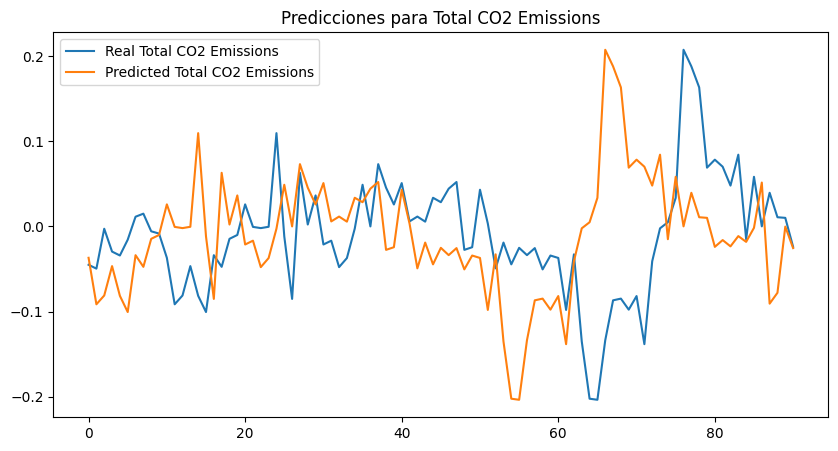

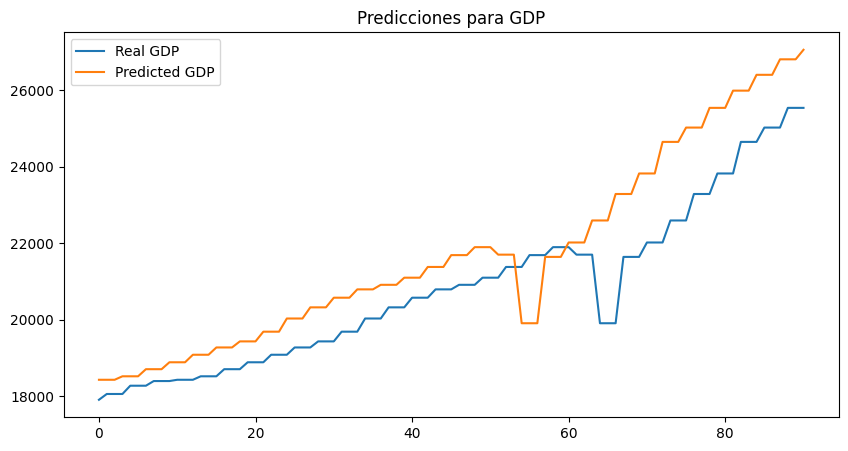

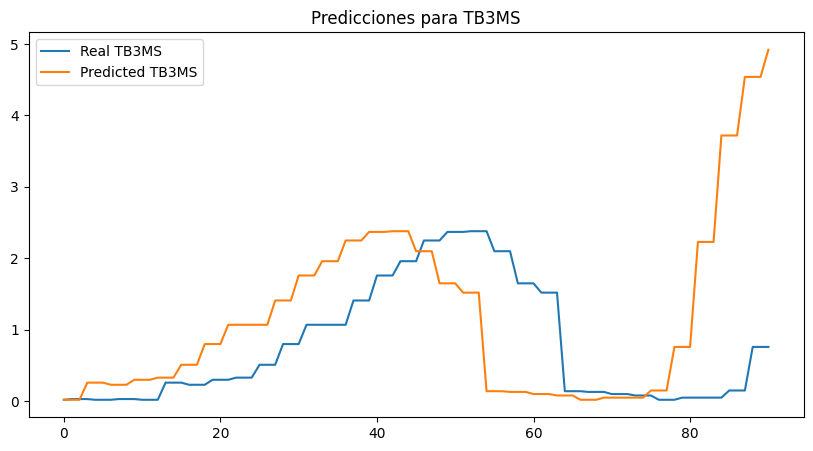

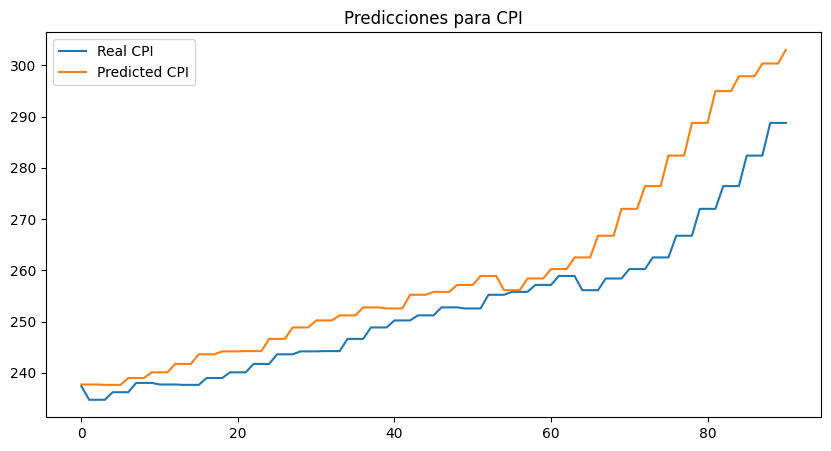

In [5]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

In [6]:
# Crear dos escenarios: optimista y pesimista
def create_optimistic_and_pessimistic_scenarios(asset_returns):
    """
    Crea dos escenarios ajustando los retornos históricos:
    - Optimista: Usa los retornos históricos normales.
    - Pesimista: Reduce los retornos en un factor pesimista.
    
    :param asset_returns: Retornos históricos de los activos.
    :return: Retornos ajustados para escenarios optimistas y pesimistas.
    """
    # Filtrar solo columnas numéricas
    numeric_returns = asset_returns.select_dtypes(include=[np.number])
    
    # Escenario optimista: usar los retornos históricos
    optimistic_returns = numeric_returns.copy()
    
    # Escenario pesimista: reducir los retornos, solo se aplican a los valores numéricos
    pessimistic_returns = numeric_returns.copy()
    pessimistic_returns.loc[:, :] = pessimistic_returns * 0.5  # Operación solo sobre los valores
    
    return optimistic_returns, pessimistic_returns



# Escenarios
optimistic_returns, pessimistic_returns = create_optimistic_and_pessimistic_scenarios(asset_prices)


# Instancia para el escenario optimista
optimizer_optimistic = PortfolioOptimizer(optimistic_returns, rf)

# Instancia para el escenario pesimista
optimizer_pessimistic = PortfolioOptimizer(pessimistic_returns, rf)

# Generar y graficar muchos portafolios para ambos escenarios
print("Escenario Optimista:")
df_optimistic, _ = optimizer_optimistic.plot_random_portfolios(num_portfolios=1000)

print("Escenario Pesimista:")
df_pessimistic, _ = optimizer_pessimistic.plot_random_portfolios(num_portfolios=1000)


Escenario Optimista:


AttributeError: 'PortfolioOptimizer' object has no attribute 'plot_random_portfolios'

In [ ]:
benchmark_prices

In [ ]:
asset_prices

In [7]:

# Asegúrate de eliminar la columna 'Date' de asset_prices y benchmark_prices si aún está presente
if 'Date' in asset_prices.columns:
    asset_prices = asset_prices.drop(columns=['Date'])

if 'Date' in benchmark_prices.columns:
    benchmark_prices = benchmark_prices.drop(columns=['Date'])

# Alinear asset_prices y benchmark_prices según el índice (fechas o índices comunes)
asset_prices, benchmark_prices = asset_prices.align(benchmark_prices, join='inner', axis=0)

# Inicializar el optimizador de portafolios
optimizer = PortfolioOptimizer(asset_prices=asset_prices, risk_free_rate=rf, benchmark_prices=benchmark_prices)

# Definir el número de portafolios a generar y las estrategias de optimización
num_portfolios = 1000
strategies = ['sharpe', 'omega', 'sortino']  # Puedes elegir las estrategias que quieras

# Optimizar el portafolio utilizando múltiples estrategias
optimal_portfolios = optimizer.optimize_with_multiple_strategies(num_portfolios=num_portfolios, strategies=strategies)

# Imprimir los mejores portafolios para cada estrategia
for strategy, portfolios in optimal_portfolios.items():
    print(f"\nMejores portafolios optimizados para {strategy}:")
    for i, (weights, score) in enumerate(portfolios[:5]):  # Muestra los 5 mejores portafolios
        print(f"Portafolio {i+1}:")
        print(f"Pesos: {weights}")
        print(f"Score ({strategy}): {score}")

# Cálculo de Jensen's Alpha para los mejores portafolios
print("\nCálculo de Jensen's Alpha para los mejores portafolios optimizados (basado en Sharpe, Omega y Sortino):")
for strategy, portfolios in optimal_portfolios.items():
    for i, (weights, _) in enumerate(portfolios[:5]):
        # Calcular Jensen's Alpha para cada uno de los mejores portafolios
        jensen_alpha = optimizer.calculate_jensen_alpha(weights)
        print(f"Portafolio {i+1} ({strategy}): Jensen's Alpha = {jensen_alpha}")



Mejores portafolios optimizados para sharpe:
Portafolio 1:
Pesos: [0.03711316 0.0457749  0.20818035 0.09430601 0.04923749 0.07608773
 0.29622866 0.16950288 0.02356881]
Score (sharpe): -0.3662194370642623
Portafolio 2:
Pesos: [0.06338851 0.00530868 0.10667054 0.09481084 0.0382009  0.05247353
 0.24165405 0.26190038 0.13559258]
Score (sharpe): -0.3667328190853632
Portafolio 3:
Pesos: [0.2696321  0.05851939 0.03296324 0.0218413  0.06421724 0.03410492
 0.29714435 0.17311791 0.04845955]
Score (sharpe): -0.384491022287778
Portafolio 4:
Pesos: [0.01776818 0.16075524 0.09114548 0.12022074 0.03384103 0.02809638
 0.22535369 0.27097695 0.0518423 ]
Score (sharpe): -0.389618193020435
Portafolio 5:
Pesos: [0.18648274 0.10514519 0.16980308 0.00352412 0.04698915 0.03601803
 0.27065883 0.14286781 0.03851105]
Score (sharpe): -0.39593460776660167

Mejores portafolios optimizados para omega:
Portafolio 1:
Pesos: [0.01600382 0.32980957 0.03721449 0.16064584 0.1770161  0.11733034
 0.01156038 0.03501861 0.11

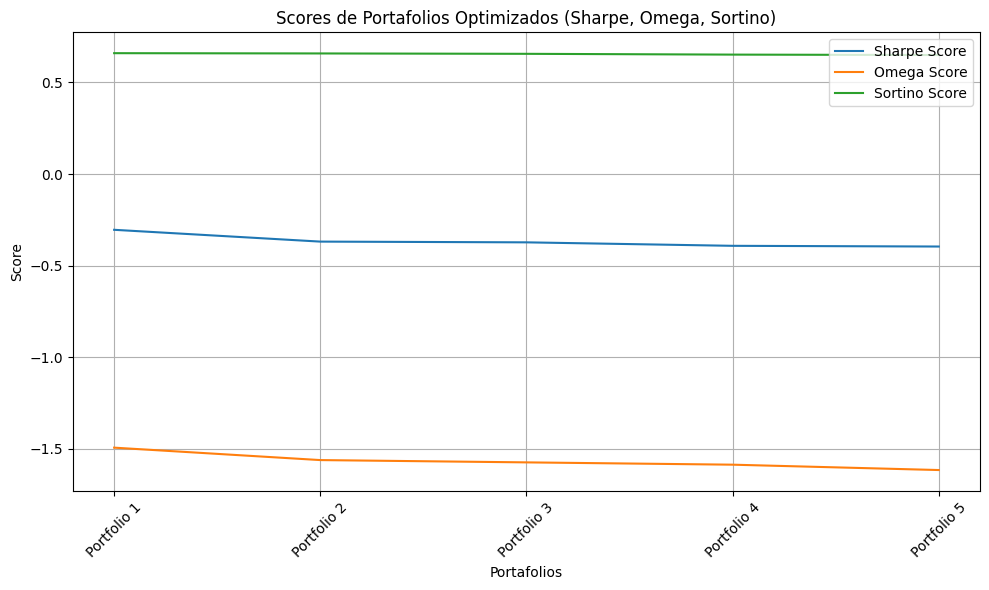

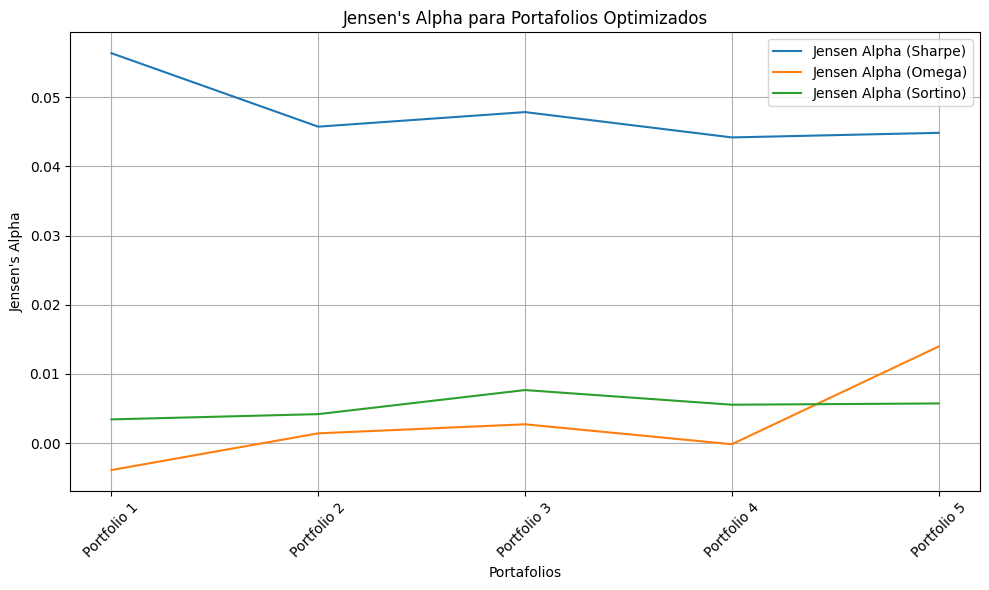

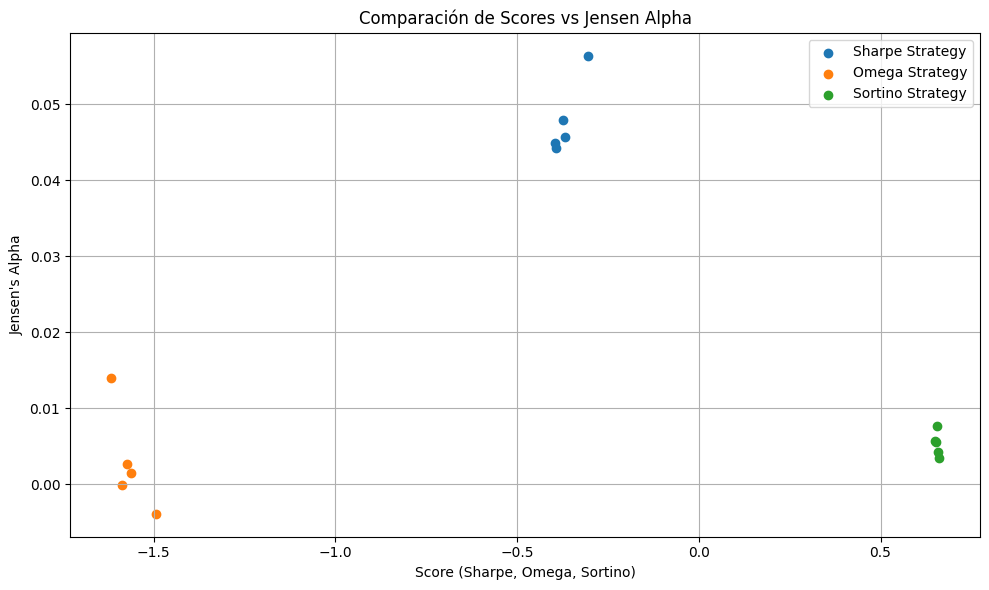

In [8]:

# Convertir los resultados a un DataFrame para facilitar la visualización
portfolios_df = pd.DataFrame(portfolios_data)

# Gráfica de los Scores de las estrategias de optimización
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.plot(strategy_data['Portfolio'], strategy_data['Score'], label=f'{strategy.capitalize()} Score')
plt.title('Scores de Portafolios Optimizados (Sharpe, Omega, Sortino)')
plt.xlabel('Portafolios')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfica de Jensen's Alpha para cada estrategia
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.plot(strategy_data['Portfolio'], strategy_data['Jensen Alpha'], label=f'Jensen Alpha ({strategy.capitalize()})')
plt.title("Jensen's Alpha para Portafolios Optimizados")
plt.xlabel('Portafolios')
plt.ylabel("Jensen's Alpha")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico comparativo de Score vs Jensen's Alpha
plt.figure(figsize=(10, 6))
for strategy in strategies:
    strategy_data = portfolios_df[portfolios_df['Strategy'] == strategy]
    plt.scatter(strategy_data['Score'], strategy_data["Jensen Alpha"], label=f'{strategy.capitalize()} Strategy')
plt.title('Comparación de Scores vs Jensen Alpha')
plt.xlabel('Score (Sharpe, Omega, Sortino)')
plt.ylabel("Jensen's Alpha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
